In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from datasets import load_dataset, load_from_disk
import pandas as pd 
import numpy as np 
import torch
from tqdm.auto import tqdm 
import os
import json

In [2]:
dataset = load_from_disk('/opt/ml/input/data/train_dataset')
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

In [27]:
sample = dataset['validation']
scores = []
for i in range(len(sample)):
    context = sample[i]['context']
    question = sample[i]['question']
    tokenized_context = tokenizer.encode(context, add_special_tokens=False)
    tokenized_question = tokenizer.encode(question, add_special_tokens=False)
    acc = 0
    em = []
    for q_token in tokenized_question:
        if q_token in tokenized_context:
            acc += 1
            em.append(int(q_token))
    acc = acc / len(tokenized_question)
    scores.append(acc)
    em = tokenizer.decode(em)
    answer = sample[i]['answers']['text'][0]
    length = len(context)
    with open('output.txt','a') as f:
        f.write(f'{i} ')
        for j in range(0, length, 100):
            f.write(f'{context[j:j+100]}\n')
        f.write(f'Q: {question} -> A: {answer}\n')
        f.write(f'SAME: {em} -> ACCURACY:{acc:.2f}\n')
        f.write('\n')

  0%|          | 0/240 [00:00<?, ?it/s]

# context vs question
문서와 질문이 매우 유사함 -> sparse가 효과가 더 좋을 수도 있음

In [30]:
print('min:',sorted(scores)[:10])
print('max:',sorted(scores)[-10:])

min: [0.38461538461538464, 0.45454545454545453, 0.46153846153846156, 0.47058823529411764, 0.47368421052631576, 0.47619047619047616, 0.5, 0.5, 0.5, 0.5]
max: [0.8846153846153846, 0.8888888888888888, 0.8947368421052632, 0.9047619047619048, 0.9047619047619048, 0.9090909090909091, 0.92, 0.9230769230769231, 0.9444444444444444, 1.0]


# wikipedia vs train_dataset
train_dataset의 `context`가 실제로 wiki데이터에서 추출한 것인지 확인

In [3]:
dataset_id = 'dnjdsxor21/wiki-kor'
wiki = load_dataset(dataset_id)
wiki

Found cached dataset parquet (/opt/ml/.cache/huggingface/datasets/dnjdsxor21___parquet/dnjdsxor21--wiki-kor-4c26046f62d63966/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    original: Dataset({
        features: ['text', 'ner'],
        num_rows: 56736
    })
})

In [12]:
sample = wiki['original']
t = '요크 카운티 동쪽에 처음'
result = []
for i in tqdm(range(len(sample)), total=len(sample)):
    text = sample[i]['text']
    if t in text:
        result.append(i)
for r in result:
    print(sample[r]['text'])
    print()

  0%|          | 0/56736 [00:00<?, ?it/s]

요크 카운티 동쪽에 처음으로 여객 열차 운행이 시작한 시점은 1868년 토론토 & 니피싱 철도의 설립 인가가 떨어졌을 때였다. 스카버러 남쪽과 코보콘크 마을을 잇는 철도 노선 공사가 시작되었고 1871년 6월에 억스브릿지까지 철도가 완공되었다. 이 노선은 이후 1871년 11월에 캐닝턴까지 연장되었고 1872년 11월에 코보콘크까지 완공되었다. \n\n이 노선의 철로 궤간은 1067mm로 협궤 노선이였다. 목재와 장작 수요가 선로 용량이 넘칠 정도로 많았지만 1870년대에 다른 철도와 마찬가지로 경제적 난황을 이기 못해 수익이 줄어들었다. 투자자들은 수익이 줄어든 이유로 철도가 협궤로 지어져서 다른 표준궤 노선과 연계하여 화물 운송을 할 수 없는 점을 들었다 \n\n1881년 7월, 미들랜드 철도가 토론토 & 니피싱 철도를 인수하였고 이 노선은 표준궤로 전환되었다. 미들랜드 철도의 영향은 스카버러에서도 볼 수 있는데 노선 동쪽을 따라 나란히 달리는 미들랜드 애비뉴가 이 철도 회사의 이름을 따서 지어졌다. 1884년, 미들랜드 철도는 그랜드 트렁크 철도에 인수되었고 이는 이후 캐나다 내셔널 철도에 다시 인수되었다. CN은 이 노선을 억스브릿지 선으로 명명하였다\n\n억스브릿지 선을 따라 달리는 여객 철도는 통근객을 위한 열차가 아니였다. 처음에는 론빌에 있는 미들랜드정션역과 토론토를 잇는 열차가 두 대씩 양방향으로 운행했고 한 대는 북동쪽으로 코보콘크까지 운행하였다. 토론토 북동쪽에 있던 시골 마을의 수요는 저조하기만 하였으며 20세기에 들어서서 도로 개량과 자동차 보편화로 쇠락의 길을 걷게 되었다\n\n1955년에는 코보콘크에서 억스브릿지까지 여객 열차 운행이 중단되었으며 30년 뒤 선로 또한 폐선되었다. 1963년에는 억스브릿지까지 이어지는 여객열차 운행이 중단되고 CN 열차는 토론토 유니언역에서 마컴으로 가는 열차를 5시 20분에 딱 한 대 운행하였다. 토론토로 돌아오는 열차는 존재하지 않았다



# wiki 데이터 길이
: 길이가 긴 문장 대부분 중국어로 이루어진 문장 -> 버려도될둣?

  0%|          | 0/56736 [00:00<?, ?it/s]

78130 184


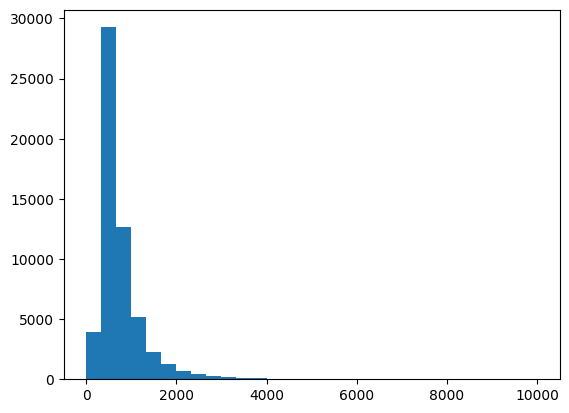

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sample = wiki['original']['text']
length = []
outlier = []
for i in tqdm(range(len(sample)), total=len(sample)):
    length.append(len(sample[i]))
    if len(sample[i]) > 20000:
        outlier.append(i)
print(max(length), min(length))
plt.hist(length, bins=30, range=(0,5000))
plt.show()

In [21]:
for i in outlier:
    print(sample[i])
    print('-'*10)

;성도(청두)시 Cheng Du Shi 

성도,간칭으로 "융"(Rong )이라고 도 한다. 아시에서 처음으로 국제"미식의 도시"(Mei Shi Zhi Du )로 이름이 났고 고대로 부터"천부지국"(Tian Fu Zhi Guo )이라는 아름다운 명칭을 얻었다.. 이백(Li Bai )의 시편 에는 "아홉개 하늘은 성도에서 나왔고 천만개의 문은 그림으로 들어 오너라" (Jiu Tian Kai Chu Yi Cheng Du ,Mo Hu Qian Men Ru Hua Tu ) 진절하게 금관성(Jin Guan Cheng )의 부유와 수려함을 묘사 하였다. 사천의 전통극은 절기하고 풍부하며 례로 타거(Tuo Ju ), 개혜안(Kai Hui Yan ), 얼굴 변하기(Bian Lian ), 불뿜기(Pen Huo ), 칼숨기기(Cang Dao )등은 사람들로 하여금 감탄을 끓이지 않 았다. 성도는 2010년 2월 28일에 "미식의 도시"로 칭호를 수여 받았다. 성도의 유명한 소식(Zhu Ming Xiao Chi )은 마퍼 두부(Ma Po Dou Fu ), 쌍류 토끼 두(Shuang Liu Tu Tou ), 부처폐편(Fu Qi Fei Pian ), 단단면(Dan Dan Mian ), 용 초수(Long Chao Shou ), 종 물 만두(Zhong Shui Jiao ), 한 만두 떡(Han Bao Zi ), 삼대 포(San Da Pao ), 뢰탕원(Lai Tang Yuan )등이다. 성도의 가장 좋은 여행 시간은 3월, 4월, 5월, 6월, 9월, 10월, 11월이며 청성산(Qing Cheng Shan ), 서령 설산(Xi Ling Xue Shan ), 구룡구(Jiu Long Gou ), 구봉산(Jiu Feng Shan ), 천대산(Tian Tai Shan ), 용지 산림공원(Long Chi Sen Lin Gong Yuan ) 등은 모두 성도의 가장 이상적인 피서 명승지이다. 성도에서 북쪽으로 올라 가다 보면 도강언(Du Jiang Yan ), 구채구(Jiu Zhai Gou )로 도

In [22]:
# length of documents
print(sorted(length, reverse=True)[:100])

[78130, 67259, 41014, 31361, 29028, 27203, 26865, 25351, 21745, 20574, 20326, 16455, 16079, 14526, 14433, 14078, 12969, 12528, 12364, 12309, 12229, 12078, 12073, 11941, 11492, 11485, 11423, 11168, 10828, 10130, 10113, 10091, 9680, 9583, 9444, 9433, 9324, 9201, 9107, 9067, 8996, 8860, 8814, 8813, 8681, 8668, 8664, 8538, 8406, 8395, 8333, 8314, 8178, 8175, 8092, 8044, 7987, 7955, 7939, 7827, 7799, 7716, 7575, 7560, 7553, 7463, 7422, 7230, 7229, 7229, 7217, 7164, 7154, 7152, 7151, 7141, 7128, 7110, 7016, 6982, 6896, 6853, 6849, 6801, 6797, 6776, 6772, 6755, 6753, 6747, 6734, 6674, 6647, 6613, 6536, 6459, 6394, 6376, 6326, 6316]
